In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
import lightgbm as lgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [86]:
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
sub = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv")

In [87]:
data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [88]:
sub.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [89]:
data.shape

(98000, 30)

In [90]:
sub.shape

(98000, 2)

**EDA**

In [91]:
data.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,...,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,...,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,...,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,...,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,...,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,...,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,...,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,...,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


<AxesSubplot:>

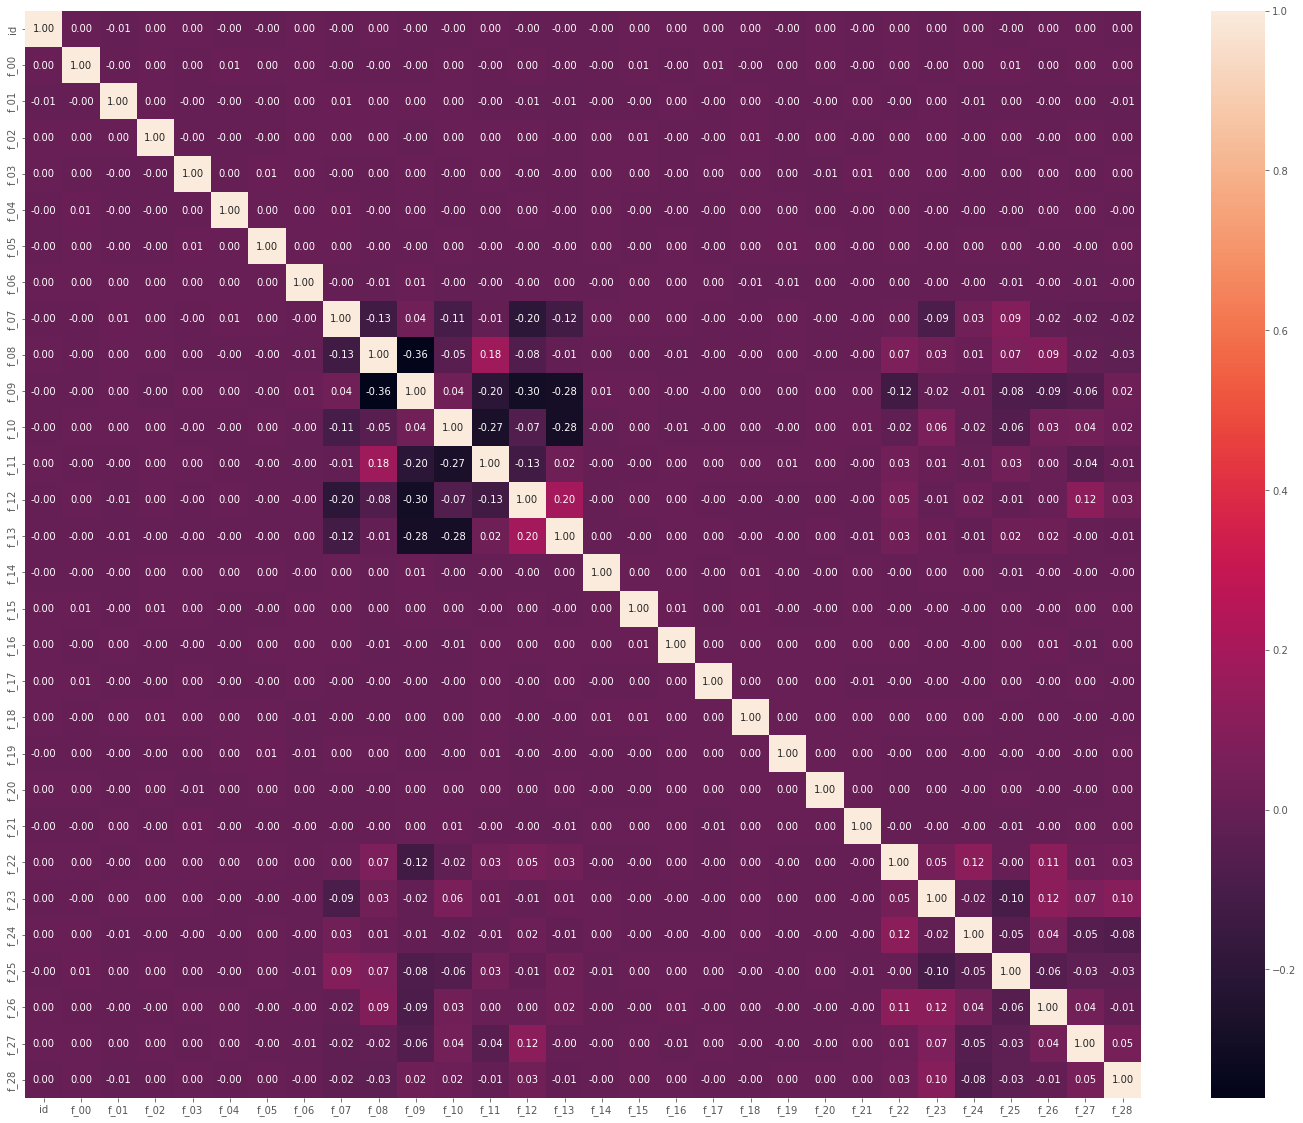

In [92]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(),annot = True,fmt = ".2f")

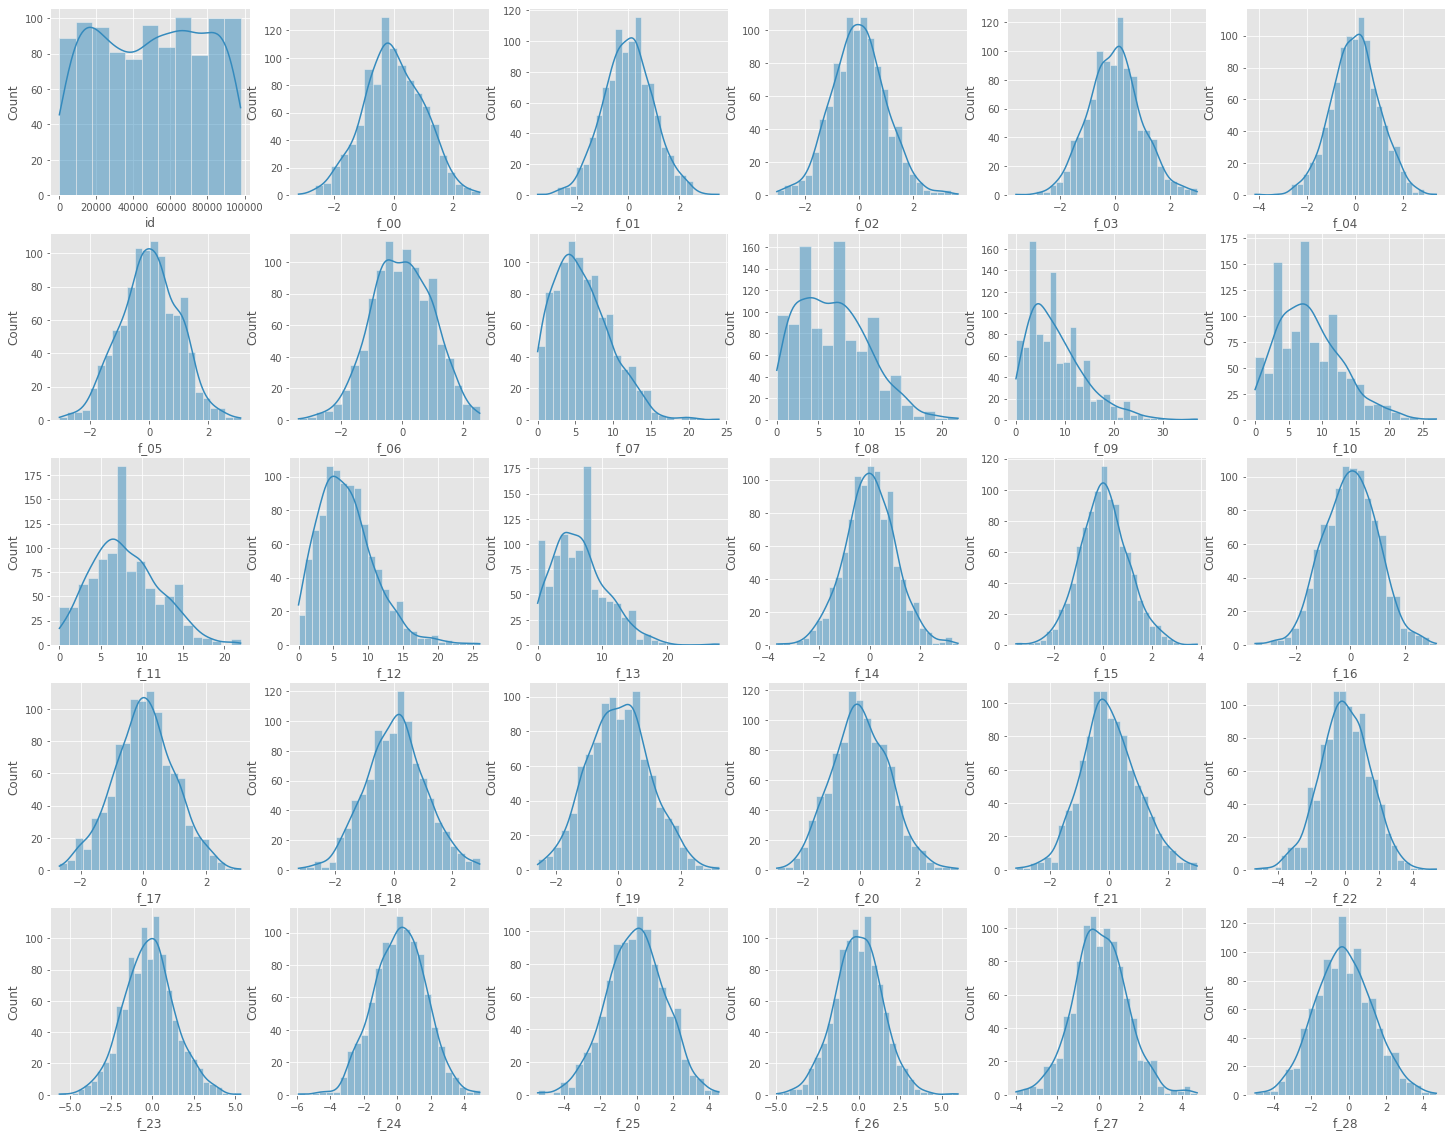

In [93]:
plt.figure(figsize = (15,10))
for i,column in enumerate(list(data.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data = data.sample(1000),kde = True)

**Feature Engineering**

In [94]:
data = data.drop(columns = "id")

In [95]:
cols = list(data.columns)

In [113]:
float_cols = data.columns[data.dtypes == 'float']
def iqr_outliers(df,col_list):
    for col in col_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2 * iqr
        Upper_tail = q3 + 2 * iqr
        df.loc[df[col] > Upper_tail,col ] = Upper_tail
        df.loc[df[col] < Lower_tail,col] = Lower_tail
    return df
data = iqr_outliers(data,float_cols)

In [96]:
data_scaled = PowerTransformer(method = "yeo-johnson").fit_transform(data)

In [114]:
data_scaled = pd.DataFrame(data_scaled,columns = cols)
data_scaled.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-0.408425,-1.598612,1.194423,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,0.620278,1.283827,0.532884,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-1.614933,-0.432406,0.321899,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058


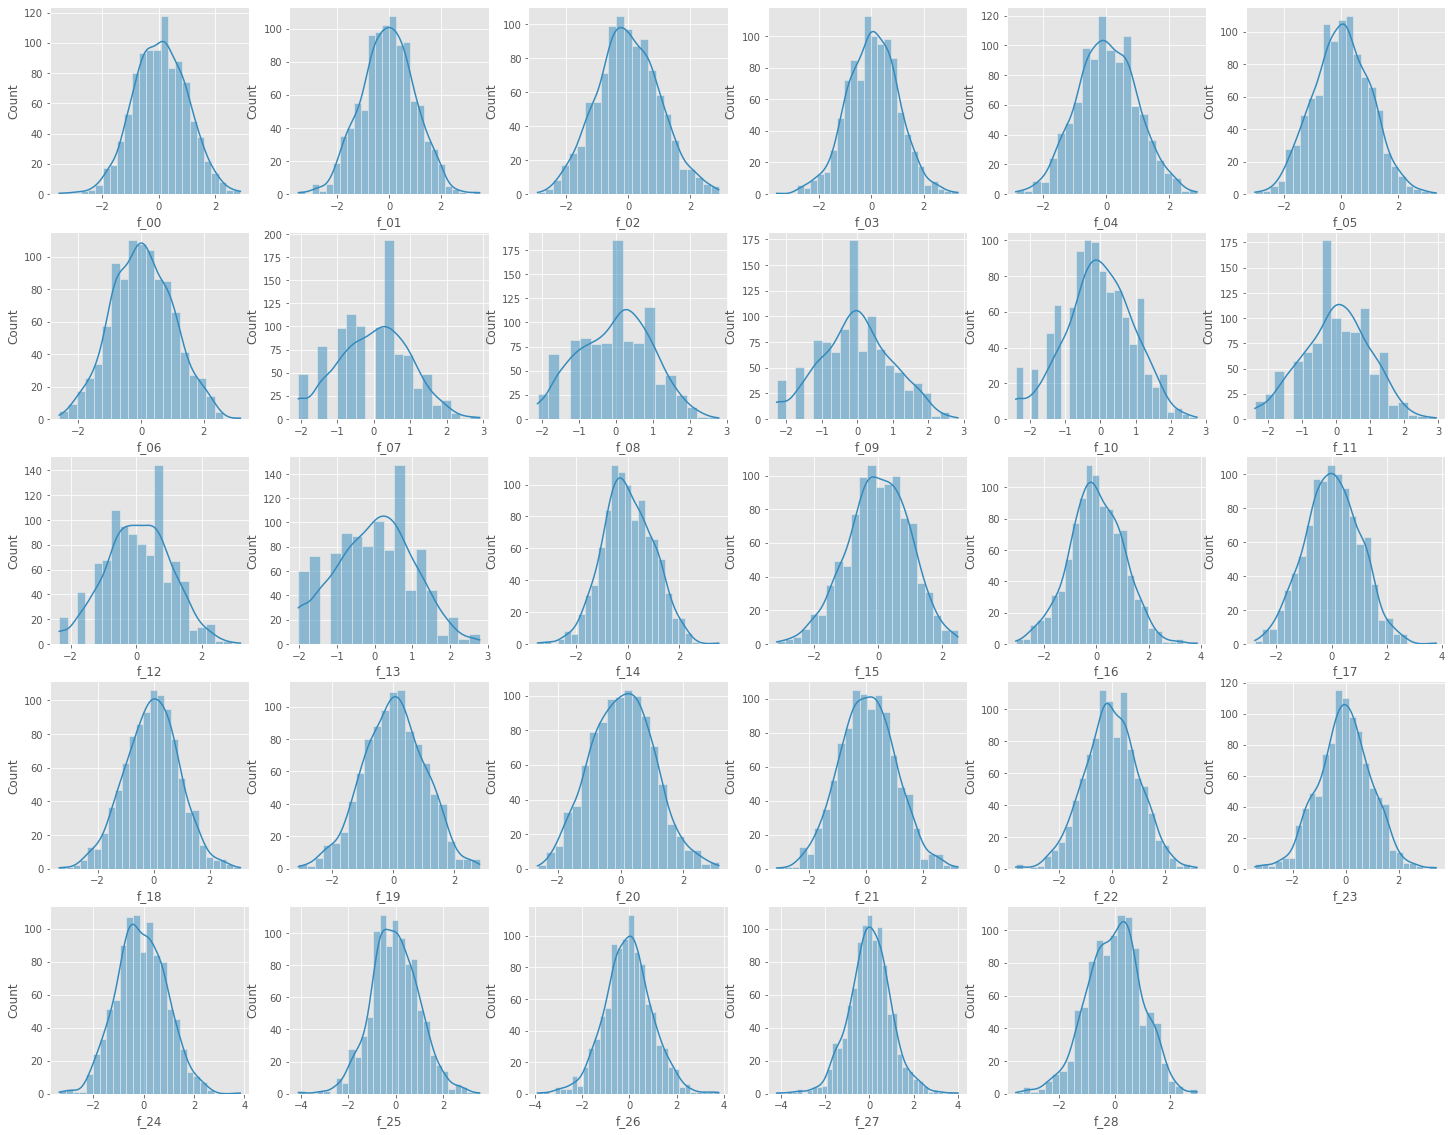

In [98]:
plt.figure(figsize = (25,20))
for i,column in enumerate(list(data_scaled.columns),1):
    plt.subplot(5,6,i)
    sns.histplot(x = column,data=data_scaled.sample(1000),kde = True)

**Model**

BayesianGaussianMixture

In [99]:
vbgmm = BayesianGaussianMixture(n_components = 7,covariance_type = 'full',random_state = 1)
preds = vbgmm.fit_predict(data_scaled)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


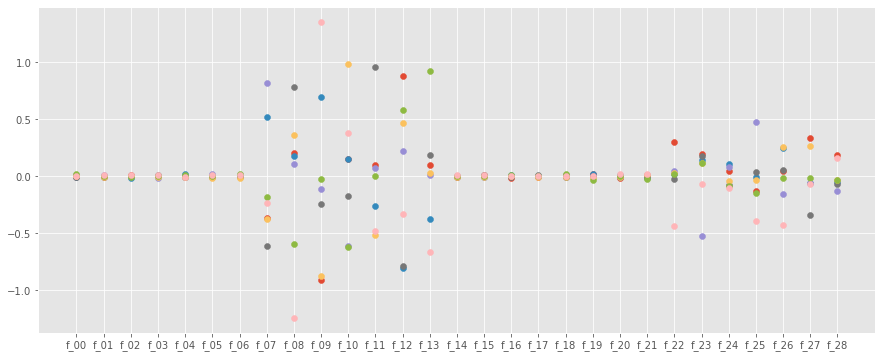

In [100]:
plt.style.use('ggplot')
plt.figure(figsize = (15,6))

for i in range(vbgmm.means_.shape[0]):
    plt.scatter(np.arange(data_scaled.shape[1]), vbgmm.means_[i])

plt.xticks(ticks = np.arange(data_scaled.shape[1]), labels=cols)
plt.show()

In [101]:
important_cols = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', ]

In [102]:
preds_vbgmm = vbgmm.fit_predict(data_scaled[important_cols])

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


In [103]:
pp = vbgmm.predict_proba(data_scaled[important_cols])

In [104]:
data_scaled[[f'predict_proba_{i}' for i in range(7)]] = pp 
data_scaled['predict_proba'] = np.max(pp,axis=1)
data_scaled['predict'] = np.argmax(pp,axis=1)
data_scaled

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_28,predict_proba_0,predict_proba_1,predict_proba_2,predict_proba_3,predict_proba_4,predict_proba_5,predict_proba_6,predict_proba,predict
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,0.694234,0.003301,0.002535,0.000413,3.315950e-03,0.014137,5.107929e-07,0.976297,0.976297,6
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-1.636652,0.017288,0.028211,0.003128,8.491771e-06,0.936769,1.429906e-02,0.000297,0.936769,4
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-2.296373,0.000100,0.000018,0.001441,1.844181e-01,0.000375,1.020798e-08,0.813647,0.813647,6
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,0.326682,0.000050,0.011117,0.026813,9.192626e-02,0.015224,8.548540e-01,0.000016,0.854854,5
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-1.160058,0.000174,0.000003,0.978602,8.047796e-06,0.021207,9.205193e-07,0.000004,0.978602,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,0.236079,1.649018,-0.688341,0.316100,-0.294857,0.330198,1.611098,0.021718,0.187543,0.191659,...,0.459507,0.002817,0.219253,0.087784,1.745836e-01,0.500474,1.209895e-03,0.013878,0.500474,4
97996,0.320923,0.704623,0.561468,-1.322145,-0.353335,0.183118,0.184227,-0.598123,0.622133,-1.243439,...,0.639735,0.008777,0.542673,0.411862,1.684192e-05,0.035973,1.233087e-08,0.000698,0.542673,1
97997,-0.249521,-0.464239,1.890043,-1.340827,0.197689,-0.557889,-0.375854,0.756900,0.622133,0.509344,...,0.584929,0.001054,0.000309,0.032805,9.505224e-01,0.008963,9.141575e-05,0.006255,0.950522,3
97998,0.309671,2.175648,0.760608,0.438831,0.466863,0.063461,-0.329904,-1.440987,0.410491,0.653205,...,0.129094,0.698102,0.037610,0.000397,1.359264e-01,0.086897,4.053226e-02,0.000535,0.698102,0


In [105]:
tr_idx = np.array([])

for n in range(7):
    idx = data_scaled[(data_scaled["predict"] == n) & (data_scaled["predict_proba"] > 0.7)].index 
    tr_idx = np.concatenate((tr_idx, idx))
    
X = data_scaled.loc[tr_idx][important_cols]
y = data_scaled.loc[tr_idx]['predict']

In [106]:
X.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
27.0,0.021718,1.203800,-0.635157,2.238616,0.517399,-0.928325,0.317221,0.611256,-0.308725,-1.252728,1.090145,-1.912390,0.438324,-0.602595
28.0,-0.598123,1.888883,-0.912475,1.054360,-0.171515,0.755755,-0.735370,-0.298416,-0.570828,-1.415415,1.050300,0.300649,-1.584098,0.515559
33.0,0.530261,-0.048856,-0.912475,1.531077,-0.682876,0.936024,-0.162832,0.027034,0.217398,-2.073375,0.830367,0.847741,0.142683,1.019868
36.0,0.530261,0.622133,-0.394246,2.104246,-0.682876,0.565556,0.533888,-0.026342,0.154460,-3.183273,2.213231,1.917207,0.043816,-0.954962
55.0,-0.270117,1.557045,-1.243439,1.054360,-0.682876,0.148356,0.086073,-0.096009,-0.718806,0.329544,-0.586925,-0.127960,-0.571388,-1.630053


In [107]:
y

27.0       0
28.0       0
33.0       0
36.0       0
55.0       0
          ..
97961.0    6
97969.0    6
97972.0    6
97989.0    6
97991.0    6
Name: predict, Length: 62415, dtype: int64

LightGBM

In [108]:
lgbm_predict_proba = 0 
kf = StratifiedKFold(5, shuffle = True, random_state = 1)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X,y)):   
    print("*****Fold {}*****".format(fold+1))
    tr_X,val_X = X.iloc[tr_idx],X.iloc[val_idx]
    tr_y,val_y = y.iloc[tr_idx],y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(tr_X,tr_y)
    lgb_eval = lgb.Dataset(val_X,val_y)
    
    params = {'learning_rate': 0.07,
              'objective': 'multiclass',
              "metric" : "multi_logloss",
              'boosting': 'gbdt',
              'verbosity': -1,
              'n_jobs': -1,
              'num_classes':7} 
    
    model = lgb.train(params, 
                      lgb_train,
                      valid_sets = [lgb_train,lgb_eval],
                      num_boost_round = 5000, 
                      callbacks = [ lgb.early_stopping(stopping_rounds = 100, verbose = True), lgb.log_evaluation(period = 100)])  

    lgbm_predict_proba += model.predict(data_scaled[important_cols])

preds = np.argmax(lgbm_predict_proba/5,axis=1)

*****Fold 1*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0234265	valid_1's multi_logloss: 0.0532125
[200]	training's multi_logloss: 0.00268664	valid_1's multi_logloss: 0.0238925
[300]	training's multi_logloss: 0.000407247	valid_1's multi_logloss: 0.0170738
[400]	training's multi_logloss: 6.75367e-05	valid_1's multi_logloss: 0.0151979
[500]	training's multi_logloss: 1.16343e-05	valid_1's multi_logloss: 0.0143951
[600]	training's multi_logloss: 2.34542e-06	valid_1's multi_logloss: 0.0141848
[700]	training's multi_logloss: 9.8754e-07	valid_1's multi_logloss: 0.0140923
[800]	training's multi_logloss: 6.5033e-07	valid_1's multi_logloss: 0.0139581
Early stopping, best iteration is:
[771]	training's multi_logloss: 7.17171e-07	valid_1's multi_logloss: 0.0139207
*****Fold 2*****
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0238461	valid_1's multi_logloss: 0.0506107
[200]	training's multi_l

**Submission**

In [109]:
sub["Predicted"] = preds

In [110]:
sub.to_csv('submission.csv', index=False)